In [10]:
%matplotlib inline
import xarray as xr
from glob import glob
import numpy as np
import pandas as pd
import cartopy.crs as ccrs   # map plots
import cartopy.feature as cfeature
from e3sm_utils import cmclimate
cmap_prect = cmclimate.cm.WhiteBlueGreenYellowRed
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [23]:
file_list = sorted(glob('/global/cscratch1/sd/feng045/FACETS/obs/stats_25km/monthly/mcs_rainhov_20??0[345678].nc'))

In [14]:
ds_hov = xr.open_mfdataset(sorted(glob('/global/cscratch1/sd/feng045/FACETS/obs/stats_25km/monthly/mcs_rainhov_20??0[345678].nc')))
ds_hov.time

<xarray.DataArray 'time' (time: 57082)>
array(['2004-03-01T00:00:00.000000000', '2004-03-01T01:00:00.000000000',
       '2004-03-01T02:00:00.000000000', ..., '2016-08-31T21:00:00.000000000',
       '2016-08-31T22:00:00.000000000', '2016-08-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2004-03-01 ... 2016-08-31T23:00:00
Attributes:
    long_name:  Epoch Time (since 1970-01-01T00:00:00)

In [27]:
for v in ds_hov.data_vars:
    print(ds_hov[v].attrs)

OrderedDict([('long_name', 'Total precipitation'), ('units', 'mm/h')])
OrderedDict([('long_name', 'MCS precipitation from regridding (Control)'), ('units', 'mm/h')])
OrderedDict([('long_name', 'MCS precipitation from tracking (Experiment)'), ('units', 'mm/h')])


In [24]:
ds_hov

<xarray.Dataset>
Dimensions:                (lon: 161, time: 57082)
Coordinates:
  * lon                    (lon) float32 -110.0 -109.75 -109.5 ... -70.25 -70.0
  * time                   (time) datetime64[ns] 2004-03-01 ... 2016-08-31T23:00:00
Data variables:
    precipitation          (time, lon) float32 dask.array<shape=(57082, 161), chunksize=(681, 161)>
    mcs_precipitation_ctl  (time, lon) float32 dask.array<shape=(57082, 161), chunksize=(681, 161)>
    mcs_precipitation_exp  (time, lon) float32 dask.array<shape=(57082, 161), chunksize=(681, 161)>
Attributes:
    title:       MCS precipitation Hovmoller
    startlat:    31.0
    endlat:      48.0
    startlon:    -110.0
    endlon:      -80.0
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Tue May 14 12:54:20 2019

In [19]:
ds_hov.attrs

OrderedDict([('title', 'MCS precipitation Hovmoller'),
             ('startlat', 31.0),
             ('endlat', 48.0),
             ('startlon', -110.0),
             ('endlon', -80.0),
             ('contact', 'Zhe Feng, zhe.feng@pnnl.gov'),
             ('created_on', 'Tue May 14 12:54:20 2019')])

In [17]:
def diurnal(da):
    return da.groupby('time.hour').mean(dim='time')

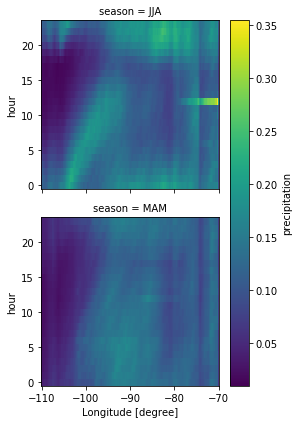

In [21]:
ds_hov['precipitation'].groupby('time.season').apply(diurnal).plot(row='season', y='hour', x='lon')

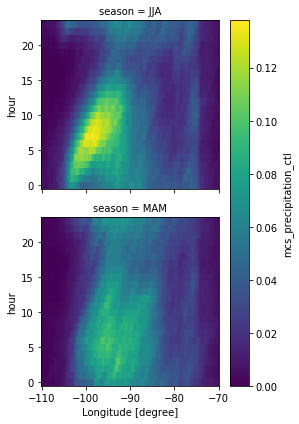

In [25]:
ds_hov['mcs_precipitation_ctl'].groupby('time.season').apply(diurnal).plot(row='season', y='hour', x='lon')

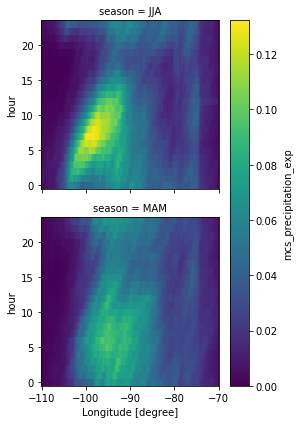

In [28]:
ds_hov['mcs_precipitation_exp'].groupby('time.season').apply(diurnal).plot(row='season', y='hour', x='lon')

In [2]:
ds_obs = xr.open_mfdataset('/global/cscratch1/sd/feng045/FACETS/obs/stats_25km/robust_mcs_tracks_2*_*.nc')
ds_obs

<xarray.Dataset>
Dimensions:             (nmaxmerge: 100, nmaxpf: 10, nmaxpix: 10000, times: 60, tracks: 5928)
Coordinates:
  * times               (times) float32 0.0 1.0 2.0 3.0 ... 56.0 57.0 58.0 59.0
  * tracks              (tracks) int64 0 1 2 3 4 5 6 ... 320 321 322 323 324 325
Dimensions without coordinates: nmaxmerge, nmaxpf, nmaxpix
Data variables:
    length              (tracks) float32 dask.array<shape=(5928,), chunksize=(304,)>
    mcs_length          (tracks) float32 dask.array<shape=(5928,), chunksize=(304,)>
    mcs_type            (tracks) int16 dask.array<shape=(5928,), chunksize=(304,)>
    starttrackresult    (tracks) float32 dask.array<shape=(5928,), chunksize=(304,)>
    endtrackresult      (tracks) float32 dask.array<shape=(5928,), chunksize=(304,)>
    base_time           (tracks, times) datetime64[ns] dask.array<shape=(5928, 60), chunksize=(304, 60)>
    julian_day          (tracks, times) float64 dask.array<shape=(5928, 60), chunksize=(304, 60)>
    datetimest

In [2]:
def select_case(name):
    assert name in ['e3sm', 'e3sm-mmf', 'FACETS', 'wrf-thompson', 'wrf-morrison']
    if name in ['e3sm', 'e3sm-mmf']:
        topdir = '/global/cscratch1/sd/crjones/ECP/' + name + '/statstb/'
        land_inits = '/global/cscratch1/sd/crjones/ECP/' + name + '/monthly_mcs_count_land_only.nc'
    elif name == 'FACETS':
        topdir = '/global/cscratch1/sd/feng045/FACETS/obs/stats_25km/'
        land_inits = None
    elif name == 'wrf-thompson':
        topdir = '/global/project/projectdirs/m1867/zfeng/usa/wrf/LGdm.THOM2011/statstb/'
        land_inits = None
    elif name == 'wrf-morrison':
        topdir = '/global/project/projectdirs/m1867/zfeng/usa/wrf/LGdm.MORR2011/statstb/'
        land_inits = None
    robust_files = sorted(glob(topdir + 'robust_mcs_tracks_20??????_20??????.nc'))
    if 'e3sm-mmf' in topdir:
        years = pd.date_range(start='2001', end='2008', freq='A-JUN')
    elif name == 'e3sm':
        years = pd.date_range(start='2001', end='2004', freq='A-JUN')
    elif name == 'FACETS':
        years = pd.date_range(start='2005', end='2017', freq='A-JUN')
    elif 'wrf' in name:
        years = pd.date_range(start='2011', end='2012', freq='A-JUN')
    if land_inits:
        ds_init = xr.open_dataset(land_inits)
    else:
        ds_init = None
    return topdir, robust_files, years, ds_init

In [3]:
def calc_mean_position(this_track, require_mcs_status=True):
    """Use largest pf"""
    pf = this_track.isel(nmaxpf=0)  # largest pf
    if require_mcs_status:
        pf = pf.where(pf.pf_mcsstatus == 1)
    lons = pf.pf_lon.values
    lats = pf.pf_lat.values
    valid_pos = ~np.isnan(lons + lats)
    lons = lons[valid_pos]
    lats = lats[valid_pos]
    lons[lons > 180] = lons[lons > 180] - 360
    month = int(np.round(pf['base_time.month'].mean()).item())
    return lons, lats, month

In [4]:
topdir, robust_files, years, ds_init = select_case('FACETS')

## Regional definitions using shapefiles

In [5]:
import shapely.geometry as sgeom
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union
from shapely.prepared import prep

In [6]:
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
# also need to add in "not land" and "Canada" :/
countries_shp = shpreader.natural_earth(resolution='110m', category='cultural',
                                        name='admin_0_countries')
land_shp = shpreader.natural_earth(resolution='110m', category='physical',
                                   name='land')
ocean_shp = shpreader.natural_earth(resolution='110m', category='physical',
                                    name='ocean')
lakes_shp = shpreader.natural_earth(resolution='110m', category='physical',
                                    name='lakes')
reader = shpreader.Reader(states_shp)
states = reader.records()

In [7]:
sgp_states = ['New Mexico', 'Texas', 'Oklahoma', 'Arkansas']
southeast_states = ['Louisiana', 'Mississippi', 'Alabama', 'Tennessee', 'Georgia', 'Florida', 'South Carolina', 'North Carolina']
ngp_states = ['Montana', 'Wyoming', 'Colorado', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas',
              'Minnesota', 'Iowa', 'Missouri', 'Wisconsin', 'Illinois', 'Indiana']
ne_states = ['Michigan', 'Ohio', 'Kentucky', 'Virginia', 'West Virginia', 'Massachusetts', 'Maryland', 'Connecticut', 
             'Pennsylvania', 'New York', 'Maine', 'Vermont', 'New Hampshire', 'Rhode Island', 'Delaware', 'New Jersey', 
             'District Of Columbia']
west_states = ['Washington', 'Idaho', 'Oregon', 'California', 'Nevada', 'Arizona', 'Utah']

geoms = [g for g in shpreader.Reader(states_shp).geometries()]
recs = [r for r in shpreader.Reader(states_shp).records()]

region_geoms = {}
for key, val in {'sgp': sgp_states,
                 'ngp': ngp_states,
                 'seast': southeast_states,
                 'ne': ne_states,
                 'west': west_states}.items():
    rgn_geoms = unary_union([rec.geometry for rec in recs if rec.attributes['name'] in val])
    region_geoms[key] = prep(rgn_geoms)

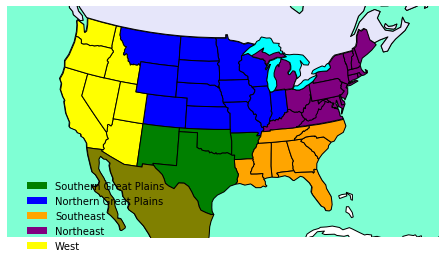

In [8]:
ax = plt.axes([0, 0, 1, 1],
              projection=ccrs.LambertConformal())
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# to get the effect of having just the states without a map "background"
# turn off the outline and background patches
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

for rec, state in zip(shpreader.Reader(states_shp).records(), shpreader.Reader(states_shp).geometries()):
    # pick a default color for the land with a black outline,
    facecolor = [0.9375, 0.9375, 0.859375]
    edgecolor = 'black'

    if rec.attributes['name'] in sgp_states:
        facecolor = 'green'
    elif rec.attributes['name'] in ngp_states:
        facecolor = 'blue'
    elif rec.attributes['name'] in southeast_states:
        facecolor = 'orange'
    elif rec.attributes['name'] in ne_states:
        facecolor = 'purple'
    elif rec.attributes['name'] in west_states:
        facecolor = 'yellow'

    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor)

for oc in shpreader.Reader(ocean_shp).geometries():
    facecolor = 'aquamarine'
    edgecolor = 'black'
    ax.add_geometries([oc], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor)

for rec in shpreader.Reader(countries_shp).records():
    if rec.attributes['NAME'] == 'Canada':
        facecolor = 'lavender'
    elif rec.attributes['NAME'] == 'Mexico':
        facecolor = 'olive'
    else:
        continue
    ax.add_geometries([rec.geometry], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor)
    
# lakes:
for rec in shpreader.Reader(lakes_shp).records():
    if rec.attributes['name_alt'] == 'Great Lakes':
        facecolor = 'aqua'
        ax.add_geometries([rec.geometry], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor=edgecolor)

    
    
# make proxy artists to add to a legend
sgp = mpatches.Rectangle((0, 0), 1, 1, facecolor="green")
ngp = mpatches.Rectangle((0, 0), 1, 1, facecolor="blue")
seast = mpatches.Rectangle((0, 0), 1, 1, facecolor="orange")
neast = mpatches.Rectangle((0, 0), 1, 1, facecolor="purple")
west = mpatches.Rectangle((0, 0), 1, 1, facecolor="yellow")
plt.legend([sgp, ngp, seast, neast, west], ['Southern Great Plains', 'Northern Great Plains', 'Southeast', 'Northeast', 'West'],
           loc='lower left', bbox_to_anchor=(0.025, -0.1), frameon=False);

In [9]:
# For classifying other regions
other_regions = {'Canada': None, 'Mexico': None,
                 'Ocean': None, 'Great Lakes': None}

# west no longer in other
# west_region = prep(unary_union([rec.geometry for rec in recs if rec.attributes['name'] in west_states]))
# other_regions['Western US'] = west_region

for rec in shpreader.Reader(countries_shp).records():
    if rec.attributes['NAME'] == 'Canada':
        other_regions['Canada'] = rec.geometry
    elif rec.attributes['NAME'] == 'Mexico':
        other_regions['Mexico'] = rec.geometry
other_regions['Ocean'] = prep(unary_union([oc for oc in shpreader.Reader(ocean_shp).geometries()]))

# note
great_lakes = [rec.geometry for rec in shpreader.Reader(lakes_shp).records() if rec.attributes['name_alt'] == 'Great Lakes']
other_regions['Great Lakes'] = prep(unary_union(great_lakes))

print(other_regions)

{'Canada': <shapely.geometry.multipolygon.MultiPolygon object at 0x2aaae2f14d30>, 'Mexico': <shapely.geometry.multipolygon.MultiPolygon object at 0x2aaae05180f0>, 'Ocean': <shapely.prepared.PreparedGeometry object at 0x2aaae2ece828>, 'Great Lakes': <shapely.prepared.PreparedGeometry object at 0x2aaae2f7ce80>}


In [10]:
def assign_mcs_region(regions, other=None, exclude=['Canada', 'Mexico', 'Ocean', 'Great Lakes'],
                      min_to_count=3):
    """
    regions = dictionary: {region_name: count}
    other (optional) = dictionary like regions with 'other' categories to exclude
    """
    if other is not None:
        regions = {**regions, **other}  # join together
    regions_to_check = {key: val for key, val in regions.items() if key not in exclude}
    # this works great if they don't tie ...
    # region_id = max(regions_to_check, key=regions.get)  # identify region as the one with max stats
    max_val = max(regions_to_check.values())
    if max_val < min_to_count:
        print('Excluded because max_val = {}'.format(max_val))
        return []
    return [key for key, value in regions_to_check.items() if value == max_val]  # returns a list

def categorize_point(point, regions, prioritize=['ngp', 'ne', 'seast', 'Canada']):
    candidates = []
    for reg, geom in regions.items():
        if geom.contains(point):
            candidates.append(reg)
    if not candidates:
        print('Uncategorized point {}'.format(point))
        return 'other'
    if len(candidates) == 1:
        return candidates[0]
    # otherwise, multiple candidate regions.
    print('Multiple regions for point {}: '.format(point), candidates)
    for priority in prioritize:
        if priority in candidates:
            print('Prioritizing ' + priority)
            return priority
    return candidates

uncategorized_pts = []
def select_mcs_region_new(this_track, region_geoms, minlen=100, other_geoms=None, debug=False):
    if this_track.majoraxislength.max().item() < minlen:
        print('track never large enough')
        return None
    if other_geoms is not None:
        region_geoms = {**region_geoms, **other_geoms}
    lons, lats, month = calc_mean_position(this_track)
    total_count = len(lons)

    lon0 = this_track.meanlon.values[0]
    if lon0 > 180:
        lon0 = lon0 - 360
    lat0 = this_track.meanlat.values[0]
    p0 = sgeom.Point(lon0, lat0)
    
    # categorize the origin
    origin = categorize_point(p0, region_geoms)
    if isinstance(origin, list):
        print('Debug this origin: ')
        print(origin)
        print(lon0, lat0)
    
    # just require it spend more time in this region than others ...
    this_region = {reg: 0 for reg in region_geoms.keys()}
    this_region['other'] = 0
    if debug:
        # will keep full list of regions for each point
        regional_breakdown = {}
    for coords in zip(lons, lats):
        point = sgeom.Point(*coords)
        region = categorize_point(point, region_geoms)
        if region == 'other':
            uncategorized_pts.append(point)
        if debug:
            regional_breakdown[coords] = categorize_point(point, region_geoms, prioritize=None)
        if isinstance(region, list):
            # next line will shulre break
            print('Debug this region: ')
            print(region)
            print(coords)
        this_region[region] += 1
    other = total_count - sum(reg_count for reg_count in this_region.values())
    if (not debug) and (other < 0):
        # something is weird here, let's see the details by cranking this out with debug:
        return select_mcs_region_new(this_track, region_geoms, minlen, other_geoms, debug=True)
    if debug:
        print({key: val for key, val in regional_breakdown.items() if len(val) > 1})
    region_id = assign_mcs_region(this_region)
    return region_id, month, origin

# ####################################
# The actual calculation starts here
# ####################################

months = np.arange(3, 11)
all_regions = [key for key in region_geoms.keys()] + [key for key in other_regions.keys()] + ['other']
regional_results = {(reg, mon): [] for reg in all_regions for mon in months}

the_cases = ['wrf-thompson', 'wrf-morrison', 'FACETS', 'e3sm', 'e3sm-mmf']
summary = {}
origin_summary = {}
for case in the_cases:
    topdir, robust_files, years, ds_init = select_case(case)
    if not ds_init:
        select_on_init_loc = False
    else:
        select_on_init_loc = True
    results = {}
    origins = {(reg1, reg2): 0 for reg1 in all_regions for reg2 in all_regions}
    for iyr, robust_mcs_filename in enumerate(robust_files):
        print('processing file {}'.format(robust_mcs_filename))
        ds = xr.open_dataset(robust_mcs_filename)
        if select_on_init_loc:
            init_type = ds_init.init_loc.isel(year=iyr).values  # 1 = land, 2 = ocean
        tracks_to_process = ds.tracks.values
        regional_results = {(reg, mon): [] for reg in all_regions for mon in months}
        for track in tracks_to_process:
            if select_on_init_loc and init_type[track] != 1:
                continue
            this_track = ds.isel(tracks=track)
            this_region, this_month, origin = select_mcs_region_new(this_track, region_geoms, other_geoms=other_regions)
            # accept that a single track may go into multiple regions ...
            for reg in this_region:
                regional_results[(reg, this_month)].append(track)
                if origin is not None:
                    origins[(reg, origin)] += 1 / len(this_region)
        results[iyr] = regional_results
    # post-process
    summary[case] = {key: [len(results[i][key]) for i in range(len(results))] for key in results[0].keys()}
    origin_summary[case] = origins
    print(origin_summary[case])

processing file /global/project/projectdirs/m1867/zfeng/usa/wrf/LGdm.THOM2011/statstb/robust_mcs_tracks_20110501_20110831.nc
Multiple regions for point POINT (-81.80394744873047 45.31081008911133):  ['Canada', 'Great Lakes']
Prioritizing Canada
Multiple regions for point POINT (-79.15592956542969 43.60267639160156):  ['Canada', 'Great Lakes']
Prioritizing Canada
Multiple regions for point POINT (-78.42754364013672 43.79720687866211):  ['Canada', 'Great Lakes']
Prioritizing Canada
Excluded because max_val = 2
Multiple regions for point POINT (-79.5439453125 42.78711318969727):  ['Canada', 'Great Lakes']
Prioritizing Canada
Multiple regions for point POINT (-88.51629638671875 48.29784774780273):  ['Canada', 'Great Lakes']
Prioritizing Canada
Multiple regions for point POINT (-86.21507263183594 48.37491989135742):  ['Canada', 'Great Lakes']
Prioritizing Canada
Excluded because max_val = 1
Multiple regions for point POINT (-85.70490264892578 47.31679153442383):  ['Canada', 'Great Lakes']
P

In [13]:
months

['Mar', 'Apr', 'May']

In [14]:
len(res)

NameError: name 'res' is not defined

In [20]:
[model for model in res]

['wrf-thompson', 'wrf-morrison', 'FACETS', 'e3sm', 'e3sm-mmf']

# Updated plot version

In [15]:
these_regions = {'Northern Great Plains': ('ngp', (0, 0)),
                 'Southern Great Plains': ('sgp', (1, 0)),
                 'Northeast': ('ne', (0, 1)),
                 'Southeast': ('seast', (1, 1)),
                }
months = np.arange(3, 11)

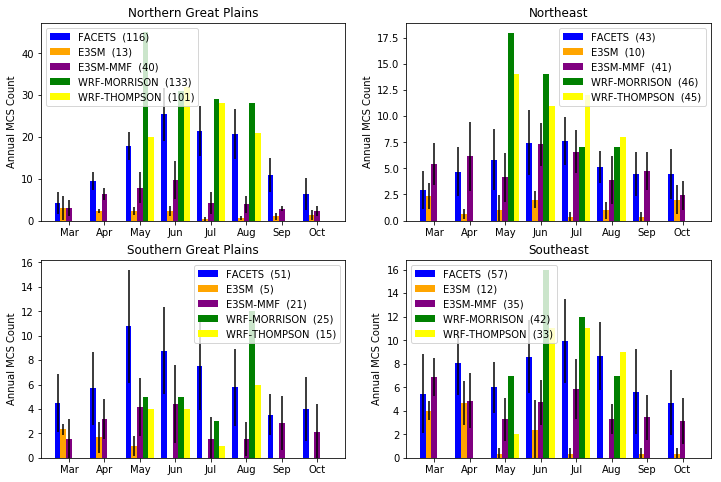

In [16]:
def gather_stats(summary, these_regions):
    nreg = len(these_regions)
    nmon = len(months)
    results = {}
    for case, summary_case in summary.items():
        out_mean = np.zeros((len(these_regions), len(months)))
        out_std = np.zeros((len(these_regions), len(months)))
        total_counts = {reg: 0 for reg in these_regions}
        for ir, reg in enumerate(these_regions):
            for im, month in enumerate(months):
                key = (reg, month)
                out_mean[ir, im] = np.mean(summary_case[key])
                out_std[ir, im] = np.std(summary_case[key])
                total_counts[reg] += sum(summary_case[key])
        results[case] = {'mean': out_mean.copy(),
                         'std': out_std.copy(),
                         'totals': total_counts.copy()
                        }
    return results

def plot_for_paper(results, these_regions, models_to_show=None, top=None):
    plot_colors = {'other': [0.9375, 0.9375, 0.859375],
                   'wrf-morrison': 'green',
                   'FACETS': 'blue',
                   'e3sm': 'orange',
                   'e3sm-mmf': 'purple',
                   'wrf-thompson': 'yellow',
                  }
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    if models_to_show is None:
        models_to_show = sorted([model for model in results])
    nmodels = len(models_to_show)
    width = 0.8 / nmodels  # width of bars in the bar plot
    for ireg, (reg, stuff) in enumerate(these_regions.items()):
        key = stuff[0]
        sp = stuff[-1]
        ax = axes[sp]
        for imodel, model in enumerate(models_to_show):
            details = res[model]
            col = plot_colors[model]
            vals = details['mean'][ireg, :]
            yerr = details['std'][ireg, :]
            label = model + '  ({:0.0f})'.format(np.sum(vals))
            pos = (months - 0.4) + (imodel + 0.5) * width
            ax.bar(pos, vals, width, yerr=yerr, label=label.upper(), color=col)
        ax.set_ylabel('Annual MCS Count')
        ax.set_xticks(months)
        ax.set_xticklabels(['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])
        ax.legend()
        ax.set_ylim(bottom=0, top=top)
        ax.set_title(reg)
        # plot month by month
res = gather_stats(summary, ['ngp', 'sgp', 'ne', 'seast'])
plot_for_paper(res, these_regions)

In [20]:
import pickle

In [22]:
with open('regional_mcs_counts.pkl', 'wb') as fp:
    pickle.dump(res, fp)

In [18]:
res

{'wrf-thompson': {'mean': array([[ 0.,  0., 20., 32., 28., 21.,  0.,  0.],
         [ 0.,  0.,  4.,  4.,  1.,  6.,  0.,  0.],
         [ 0.,  0., 14., 11., 12.,  8.,  0.,  0.],
         [ 0.,  0.,  2., 11., 11.,  9.,  0.,  0.]]),
  'std': array([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]),
  'totals': {'ngp': 101, 'sgp': 15, 'ne': 45, 'seast': 33}},
 'wrf-morrison': {'mean': array([[ 0.,  0., 45., 31., 29., 28.,  0.,  0.],
         [ 0.,  0.,  5.,  5.,  3., 12.,  0.,  0.],
         [ 0.,  0., 18., 14.,  7.,  7.,  0.,  0.],
         [ 0.,  0.,  7., 16., 12.,  7.,  0.,  0.]]),
  'std': array([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]),
  'totals': {'ngp': 133, 'sgp': 25, 'ne': 46, 'seast': 42}},
 'FACETS': {'mean': array([[ 4.15384615,  9.46153846, 17

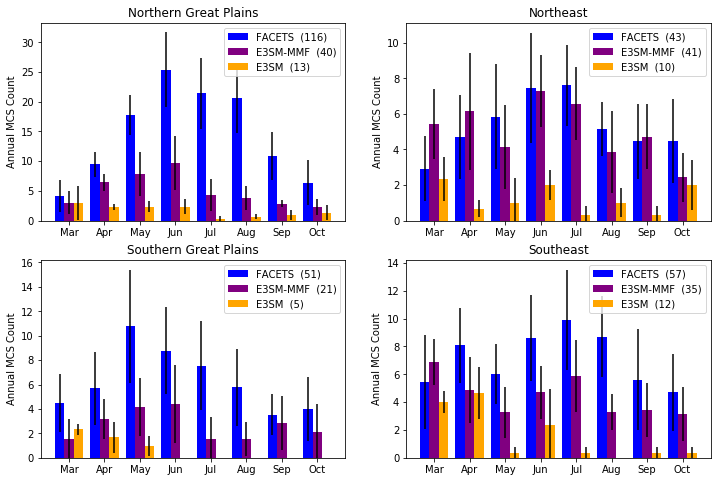

In [17]:
plot_for_paper(res, these_regions, models_to_show=['FACETS', 'e3sm-mmf', 'e3sm'])

In [19]:
res

{'wrf-thompson': {'mean': array([[ 0.,  0., 20., 32., 28., 21.,  0.,  0.],
         [ 0.,  0.,  4.,  4.,  1.,  6.,  0.,  0.],
         [ 0.,  0., 14., 11., 12.,  8.,  0.,  0.],
         [ 0.,  0.,  2., 11., 11.,  9.,  0.,  0.]]),
  'std': array([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]),
  'totals': {'ngp': 101, 'sgp': 15, 'ne': 45, 'seast': 33}},
 'wrf-morrison': {'mean': array([[ 0.,  0., 45., 31., 29., 28.,  0.,  0.],
         [ 0.,  0.,  5.,  5.,  3., 12.,  0.,  0.],
         [ 0.,  0., 18., 14.,  7.,  7.,  0.,  0.],
         [ 0.,  0.,  7., 16., 12.,  7.,  0.,  0.]]),
  'std': array([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]),
  'totals': {'ngp': 133, 'sgp': 25, 'ne': 46, 'seast': 42}},
 'FACETS': {'mean': array([[ 4.15384615,  9.46153846, 17

# Updated categorization breakdown

In [24]:
all_regions = ['sgp', 'ngp', 'seast', 'ne', 'west', 'other']

In [42]:
plot_colors = {'other': [0.9375, 0.9375, 0.859375],
               'sgp': 'green',
               'ngp': 'blue',
               'seast': 'orange',
               'ne': 'purple',
               'west': 'yellow'}

def parse_and_plot(summary, case, top=48):
    summary_case = summary[case]
    nreg = len(all_regions)
    nmon = len(months)
    out_mean = np.zeros((len(all_regions), len(months)))
    out_std = np.zeros((len(all_regions), len(months)))
    total_counts = {reg: 0 for reg in all_regions}
    for ir, reg in enumerate(all_regions):
        for im, month in enumerate(months):
            key = (reg, month)
            out_mean[ir, im] = np.mean(summary_case[key])
            out_std[ir, im] = np.std(summary_case[key])
            total_counts[reg] += sum(summary_case[key])
    # make the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    width = 0.8 / nreg  # the width of the bars
    for ir in range(nreg):
        reg = all_regions[ir]
        col = plot_colors[reg] if reg in plot_colors else plot_colors['other']
        lab = reg + '  ({:0.0f})'.format(np.sum(out_mean[ir, :]))
        pos = (months - 0.4) + (ir + 0.5) * width
        ax.bar(pos, out_mean[ir, :], width, yerr=out_std[ir, :], label=lab.upper(), color=col)
    ax.set_ylabel('Number of MCSs')
    ax.set_title('Number of MCSs for ' + case.upper() + ' ({} years)'.format(len(summary_case[key])))
    ax.set_xticks(months)
    ax.set_xticklabels(['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])
    ax.legend()
    ax.set_ylim(bottom=0, top=top)
    return out_mean, out_std, ax

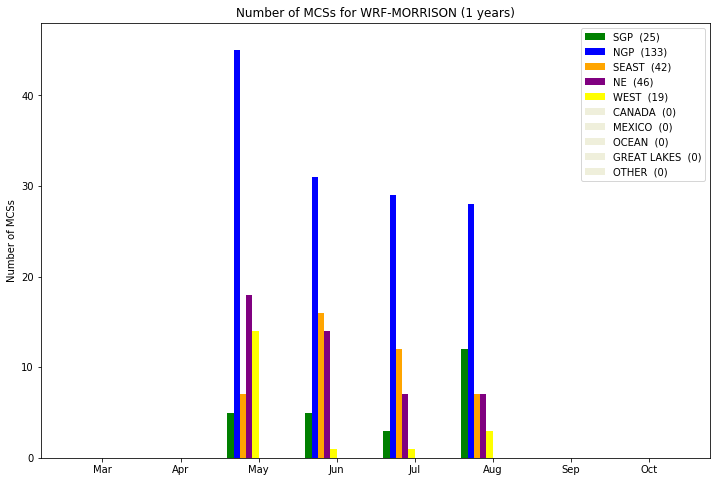

In [43]:
parse_and_plot(summary, 'wrf-morrison');

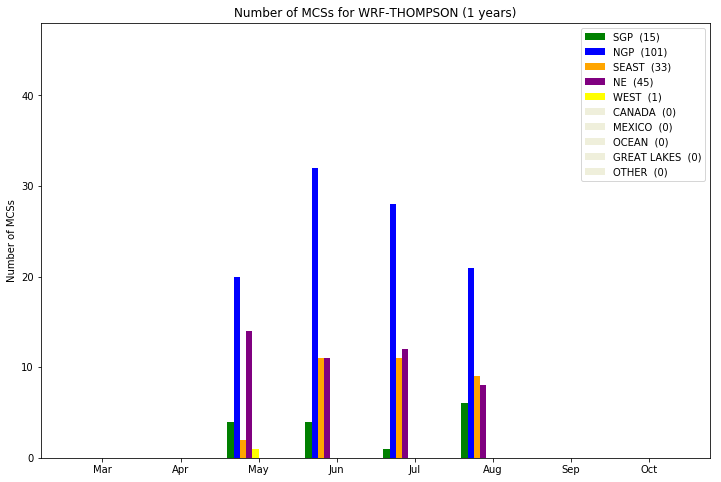

In [44]:
parse_and_plot(summary, 'wrf-thompson');

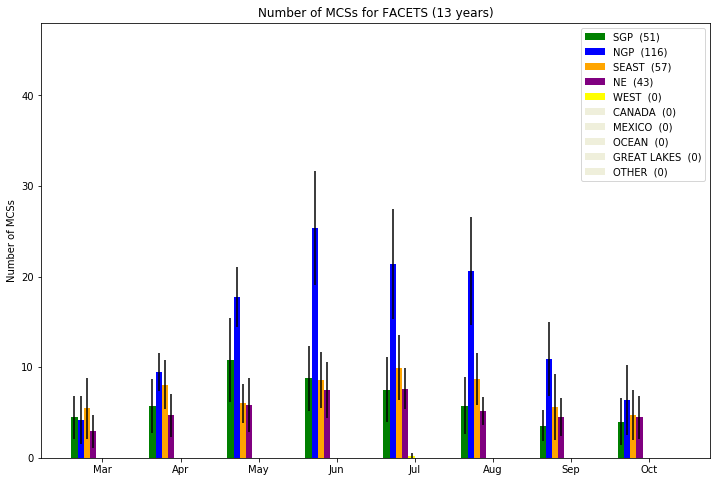

In [45]:
parse_and_plot(summary, 'FACETS');

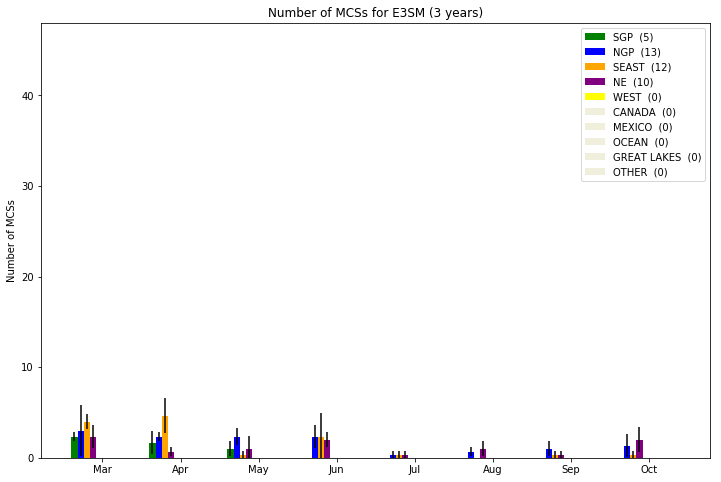

In [47]:
parse_and_plot(summary, 'e3sm');

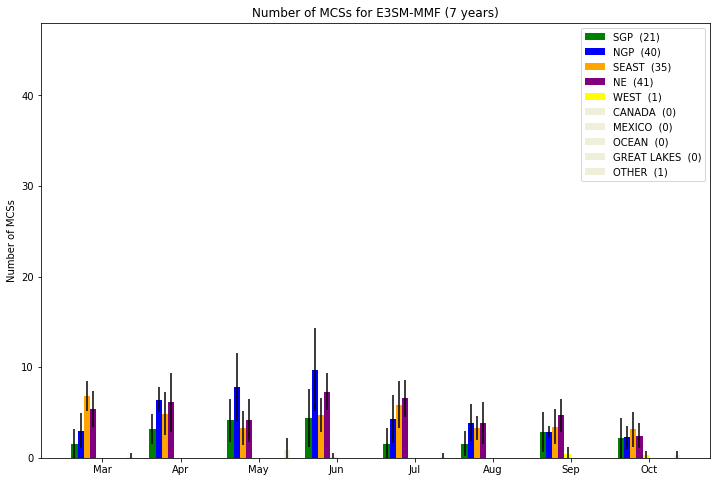

In [48]:
parse_and_plot(summary, 'e3sm-mmf');

In [46]:
len(uncategorized_pts)

118

In [28]:
import seaborn as sns
import pandas as pd

In [29]:
dfs = {}
for case, dat in origin_summary.items():
    # print(val for val in dat.values())
    ser = pd.Series(list(dat.values()),
                          index=pd.MultiIndex.from_tuples(dat.keys()))
    dfs[case] = ser.unstack().fillna(0)

Text(0.5, 1.0, 'FACETS')

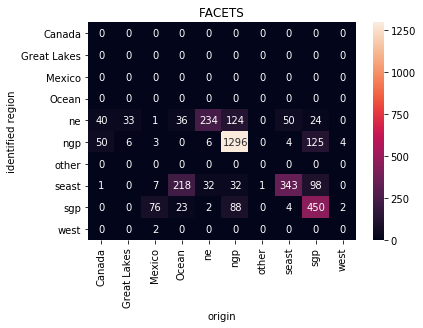

In [32]:
ax = sns.heatmap(dfs['FACETS'], annot=True, fmt='.0f')
ax.set_xlabel('origin')
ax.set_ylabel('identified region')
ax.set_title('FACETS')